<a href="https://colab.research.google.com/github/ginSpirit/ml-lab/blob/main/NN_lab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import os
import pandas as pd
import numpy as np
from zipfile import ZipFile
from google.colab import drive
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, confusion_matrix
import random

In [7]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [8]:
with ZipFile("/content/drive/My Drive/nn/archive.zip", 'r') as zip_ref:
    zip_ref.extractall()

In [9]:
train_dir = "/content/Train_Test_Valid/Train"
val_dir = "/content/Train_Test_Valid/valid"
test_dir = "/content/Train_Test_Valid/test/"

print(f"Train Directory : {train_dir}")
print(f"Validation Directory : {val_dir}")
print(f"Test Directory : {test_dir}")

Train Directory : /content/Train_Test_Valid/Train
Validation Directory : /content/Train_Test_Valid/valid
Test Directory : /content/Train_Test_Valid/test/


In [10]:
total_class_train = len(os.listdir('/content/Train_Test_Valid/Train'))
total_class_val = len(os.listdir('/content/Train_Test_Valid/valid'))
total_test = len(os.listdir('/content/Train_Test_Valid/test/'))

print(f"Total of Train Data Classes: {total_class_train} classes")
print(f"Total of Validation Data Classes: {total_class_val} classes")
print(f"Total of Test Data: {total_test} images")

Total of Train Data Classes: 6 classes
Total of Validation Data Classes: 6 classes
Total of Test Data: 6 images


In [11]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_datagen = ImageDataGenerator(rescale=1./255)

In [12]:
training_set = train_datagen.flow_from_directory(
    '/content/Train_Test_Valid/Train',
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical'
)

Found 900 images belonging to 6 classes.


In [13]:
validation_set = val_datagen.flow_from_directory(
    '/content/Train_Test_Valid/valid',
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical'
)

Found 39 images belonging to 6 classes.


In [14]:
def count_data_per_class(path):
    classes = sorted(os.listdir(path))
    class_counts = {}
    for cls in classes:
        class_path = os.path.join(path, cls)
        if os.path.isdir(class_path):
            class_counts[cls] = len(os.listdir(class_path))
    return class_counts


train_class_counts = count_data_per_class(train_dir)
val_class_counts = count_data_per_class(val_dir)

train_counts_df = pd.DataFrame.from_dict(train_class_counts, orient="index", columns=["Count"])
val_counts_df = pd.DataFrame.from_dict(val_class_counts, orient="index", columns=["Count"])

In [15]:
print(f"Total Image for Training: {sum(train_class_counts.values())} images")
print(f"Total Image for Validation: {sum(val_class_counts.values())} images")

Total Image for Training: 900 images
Total Image for Validation: 39 images


In [16]:
print(train_counts_df)

                         Count
Moon_jellyfish             150
barrel_jellyfish           150
blue_jellyfish             150
compass_jellyfish          150
lions_mane_jellyfish       150
mauve_stinger_jellyfish    150


In [17]:
print(val_counts_df)

                         Count
Moon_jellyfish               6
barrel_jellyfish             5
blue_jellyfish               7
compass_jellyfish            7
lions_mane_jellyfish         7
mauve_stinger_jellyfish      7


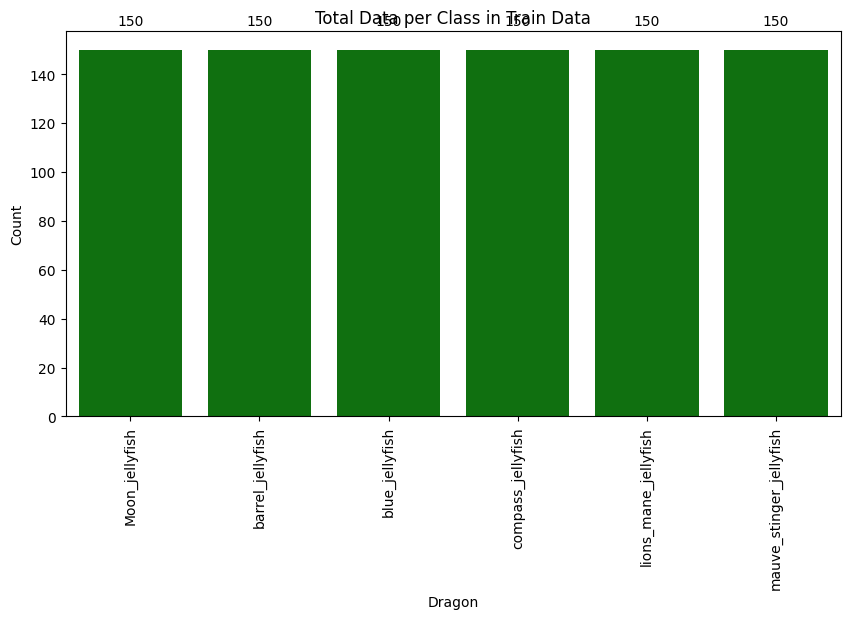

In [18]:
plt.figure(figsize=(10, 5))
sns.barplot(data=train_counts_df, x=train_counts_df.index, y="Count", color="Green")
plt.title("Total Data per Class in Train Data")
plt.xlabel("Dragon")
plt.ylabel("Count")
plt.xticks(rotation=90)


ax = plt.gca()


for p in ax.patches:
    ax.text(p.get_x()+p.get_width()/2.,
            p.get_height()+10,
            '{:1.0f}'.format(p.get_height()),
            ha="center")

plt.savefig("drive/MyDrive/nn/Total Data per Class in Train Data.jpg")

plt.show()

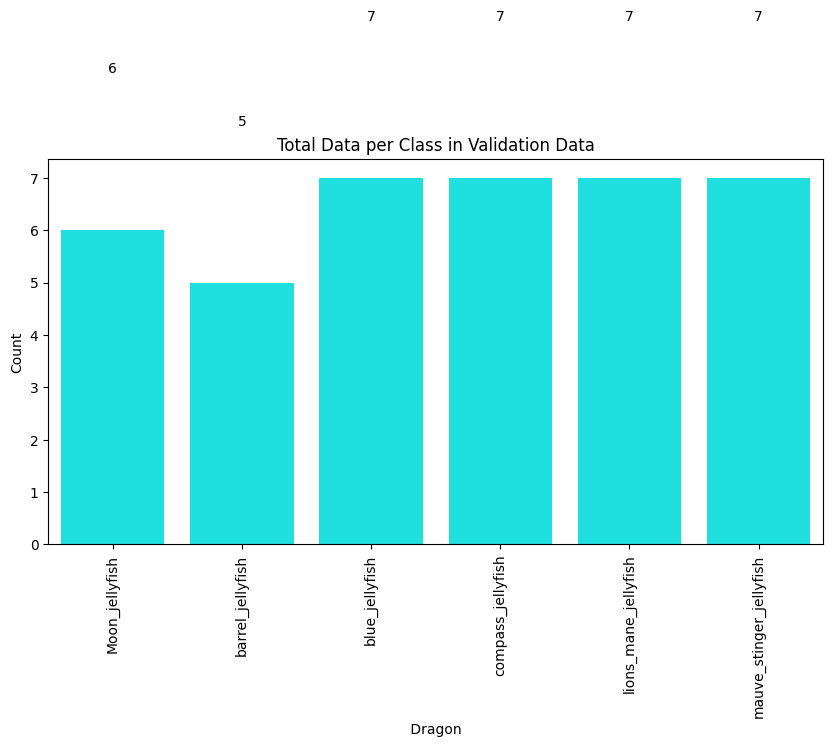

In [19]:
plt.figure(figsize=(10, 5))
sns.barplot(data=val_counts_df, x=val_counts_df.index, y="Count", color="cyan")
plt.title("Total Data per Class in Validation Data")
plt.xlabel(" Dragon ")
plt.ylabel("Count")
plt.xticks(rotation=90)

ax = plt.gca()

for p in ax.patches:
    ax.text(p.get_x()+p.get_width()/2.,
            p.get_height()+3,
            '{:1.0f}'.format(p.get_height()),
            ha="center")

plt.savefig("drive/MyDrive/nn/Total Data per Class in Validation Data.jpg")

plt.show()


Total Number of Images in Directory: 900


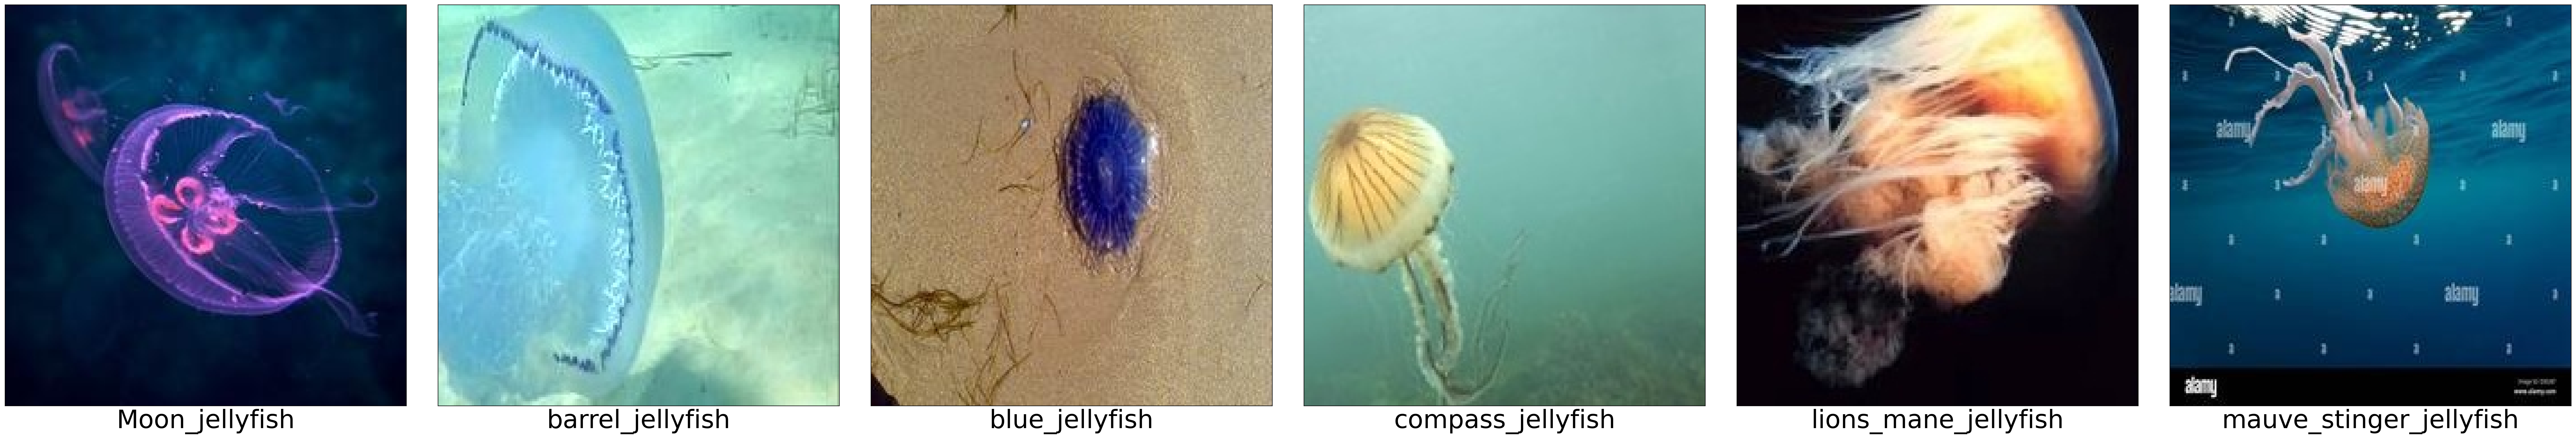

In [20]:
plt.figure(figsize=(60, 60), dpi=200)
cnt = 0
tot_images = 0

classes = sorted(os.listdir(train_dir))

for i in classes:
    cnt += 1
    plt.subplot(7, 7, cnt)

    image_path = os.listdir(os.path.join(train_dir, i))
    tot_images += len(image_path)


    if image_path:
        img_show = plt.imread(os.path.join(train_dir, i, random.choice(image_path)))
        plt.imshow(img_show)
        plt.xlabel(i, fontsize=36)
        plt.xticks([])
        plt.yticks([])
    else:
        print(f"No images found in directory: {os.path.join(train_dir, i)}")

print(f"\nTotal Number of Images in Directory: {tot_images}")
plt.tight_layout()
plt.show()

In [21]:
def create_cnn_model():
    input_tensor = Input(shape=(256, 256, 3))

    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_tensor)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)

    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    output_tensor = Dense(6, activation='softmax')(x) # Changed from 4 to 6

    model = Model(inputs=input_tensor, outputs=output_tensor)
    return model

model = create_cnn_model()

In [22]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [23]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 256, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 131072)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    67,109,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │         3,078 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 67,205,702 (256.37 MB)

 Trainable params: 67,205,702 (256.37 MB)

 Non-trainable params: 0 (0.00 B)

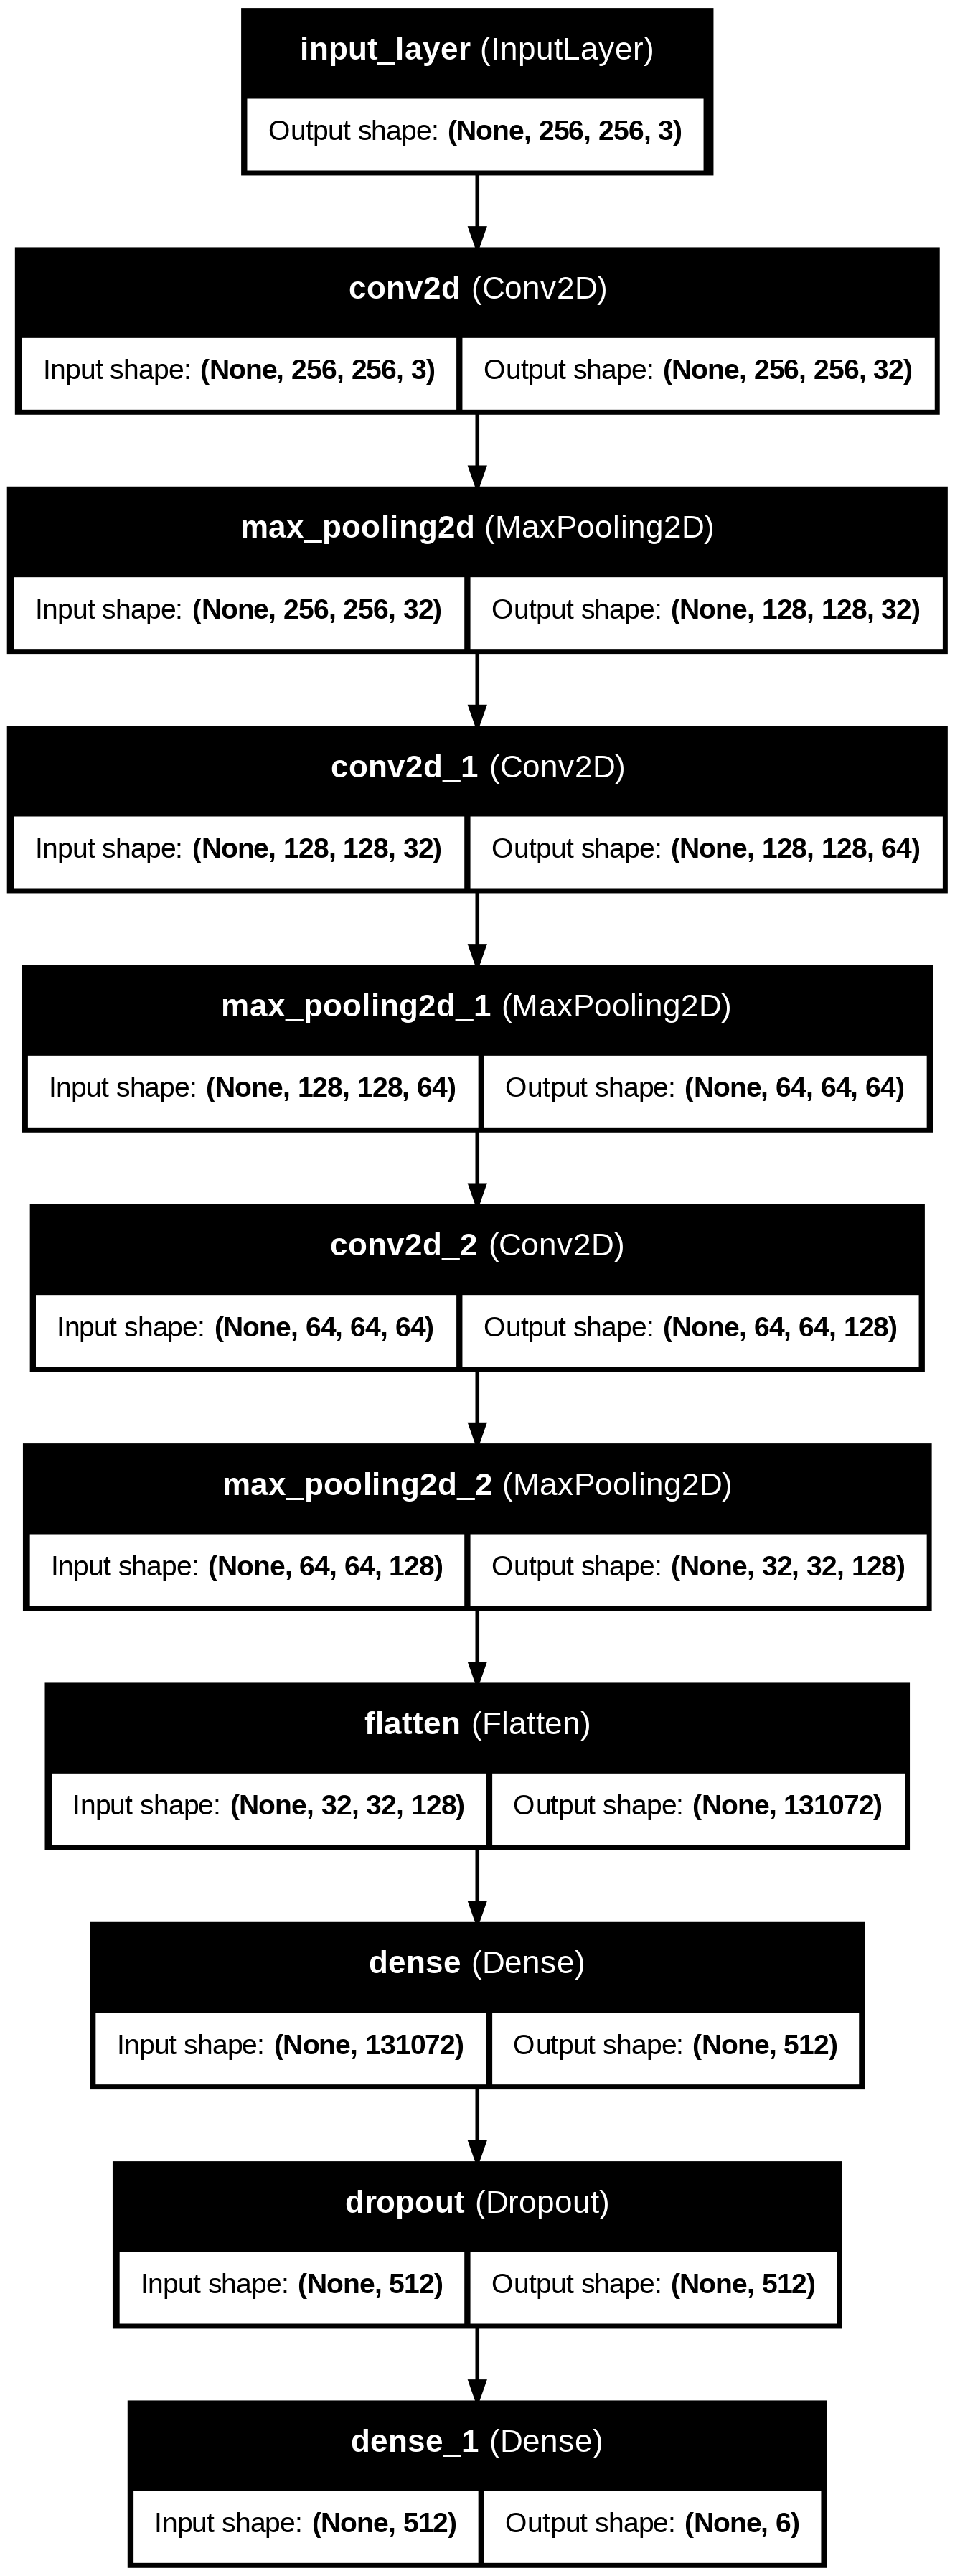

In [24]:
tf.keras.utils.plot_model(model, to_file='model_layers.png', show_shapes=True, show_layer_names=True)

In [25]:
ep = 30
training_history = model.fit(
    training_set,
    validation_data=validation_set,
    epochs=ep,
    )

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 33s 772ms/step - accuracy: 0.2131 - loss: 1.8134 - val_accuracy: 0.4359 - val_loss: 1.4750
Epoch 2/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 15s 528ms/step - accuracy: 0.3427 - loss: 1.5759 - val_accuracy: 0.4359 - val_loss: 1.3370
Epoch 3/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 15s 514ms/step - accuracy: 0.4306 - loss: 1.4047 - val_accuracy: 0.4103 - val_loss: 1.3453
Epoch 4/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 15s 512ms/step - accuracy: 0.4498 - loss: 1.3752 - val_accuracy: 0.4615 - val_loss: 1.2776
Epoch 5/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 15s 518ms/step - accuracy: 0.4996 - loss: 1.2542 - val_accuracy: 0.4103 - val_loss: 1.2997
Epoch 6/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 15s 514ms/step - accuracy: 0.4669 - loss: 1.2806 - val_accuracy: 0.4359 - val_loss: 1.2504
Epoch 7/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 15s 534ms/step - accuracy: 0.5435 - loss: 1.1767 - val_accuracy: 0.4359 - val_loss: 1.2583
Epoch 8/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 16s 539ms/step - accuracy: 0.4985 - loss: 1.2458 - val_accu

In [26]:
train_loss, train_acc = model.evaluate(training_set)
print('Training accuracy:', train_acc)

29/29 ━━━━━━━━━━━━━━━━━━━━ 15s 531ms/step - accuracy: 0.7725 - loss: 0.6472
Training accuracy: 0.7688888907432556


In [27]:
train_loss, train_acc = model.evaluate(training_set)
print('Training accuracy:', train_acc)

29/29 ━━━━━━━━━━━━━━━━━━━━ 14s 487ms/step - accuracy: 0.7815 - loss: 0.6247
Training accuracy: 0.7833333611488342


In [28]:
model.save('drive/MyDrive/nn/final_prediction_model.h5')

In [29]:
training_history.history

{'accuracy': [0.27000001072883606,
  0.378888875246048,
  0.4377777874469757,
  0.4611110985279083,
  0.49666666984558105,
  0.4866666793823242,
  0.5377777814865112,
  0.5255555510520935,
  0.5766666531562805,
  0.550000011920929,
  0.5566666722297668,
  0.5955555438995361,
  0.596666693687439,
  0.6177777647972107,
  0.6122221946716309,
  0.6266666650772095,
  0.6244444251060486,
  0.6200000047683716,
  0.6111111044883728,
  0.6299999952316284,
  0.6544444561004639,
  0.644444465637207,
  0.6611111164093018,
  0.6688888669013977,
  0.6944444179534912,
  0.6722221970558167,
  0.6933333277702332,
  0.6977777481079102,
  0.6977777481079102,
  0.6888889074325562],
 'loss': [1.7384594678878784,
  1.5267776250839233,
  1.3832849264144897,
  1.3230701684951782,
  1.2459677457809448,
  1.2720065116882324,
  1.1821504831314087,
  1.1730402708053589,
  1.1244920492172241,
  1.1431005001068115,
  1.1262739896774292,
  1.0554951429367065,
  1.032814383506775,
  0.9890466928482056,
  0.9905197620

In [30]:
model = tf.keras.models.load_model('drive/MyDrive/nn/final_prediction_model.h5')

In [31]:
test_set = val_datagen.flow_from_directory(
    val_dir,
    target_size=(256, 256),
    batch_size=1,
    class_mode='categorical',
    shuffle=False
)

Found 39 images belonging to 6 classes.


In [32]:
y_true = test_set.classes
y_pred = model.predict(test_set)
y_pred_classes = np.argmax(y_pred, axis=1)

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [33]:
class_names = list(training_set.class_indices.keys())
print(classification_report(y_true, y_pred_classes, target_names=class_names))

                         precision    recall  f1-score   support

         Moon_jellyfish       0.50      0.33      0.40         6
       barrel_jellyfish       0.60      0.60      0.60         5
         blue_jellyfish       0.50      0.71      0.59         7
      compass_jellyfish       0.83      0.71      0.77         7
   lions_mane_jellyfish       0.75      0.86      0.80         7
mauve_stinger_jellyfish       0.50      0.43      0.46         7

               accuracy                           0.62        39
              macro avg       0.61      0.61      0.60        39
           weighted avg       0.62      0.62      0.61        39



In [34]:
precision = precision_score(y_true, y_pred_classes, average='micro') * 100
recall = recall_score(y_true, y_pred_classes, average='micro') * 100
f1 = f1_score(y_true, y_pred_classes, average='micro') * 100

In [35]:
print("Precision Score : {:.2f} %".format(precision))
print("Recall Score    : {:.2f} %".format(recall))
print("F1 Score        : {:.2f} %".format(f1))

Precision Score : 61.54 %
Recall Score    : 61.54 %
F1 Score        : 61.54 %


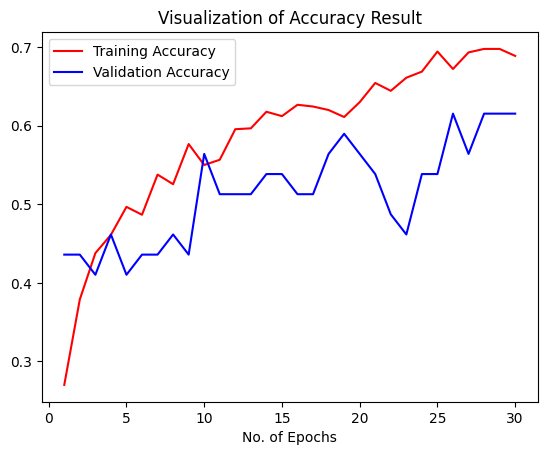

<Figure size 640x480 with 0 Axes>

In [36]:
epochs = range(1, len(training_history.history['accuracy']) + 1)
plt.plot(epochs, training_history.history['accuracy'], color='red', label='Training Accuracy')
plt.plot(epochs, training_history.history['val_accuracy'], color='blue', label='Validation Accuracy')
plt.xlabel('No. of Epochs')
plt.title('Visualization of Accuracy Result')
plt.legend()
plt.show()
plt.savefig('drive/MyDrive/nn/visualization_accuracy.jpg')

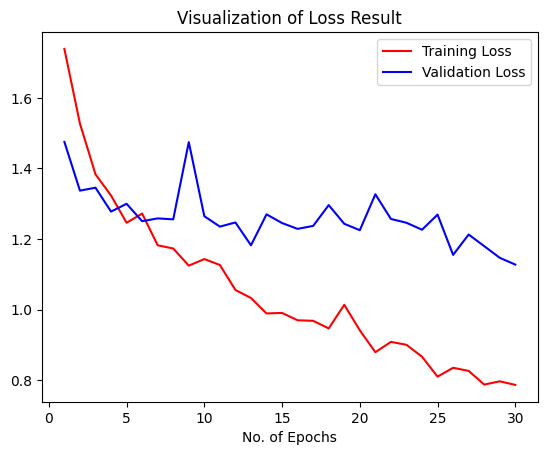

<Figure size 640x480 with 0 Axes>

In [37]:
epochs = range(1, len(training_history.history['accuracy']) + 1)
plt.plot(epochs, training_history.history['loss'], color='red', label='Training Loss')
plt.plot(epochs, training_history.history['val_loss'], color='blue', label='Validation Loss')
plt.xlabel('No. of Epochs')
plt.title('Visualization of Loss Result')
plt.legend()
plt.show()
plt.savefig('drive/MyDrive/nn/visualization_loss.jpg')

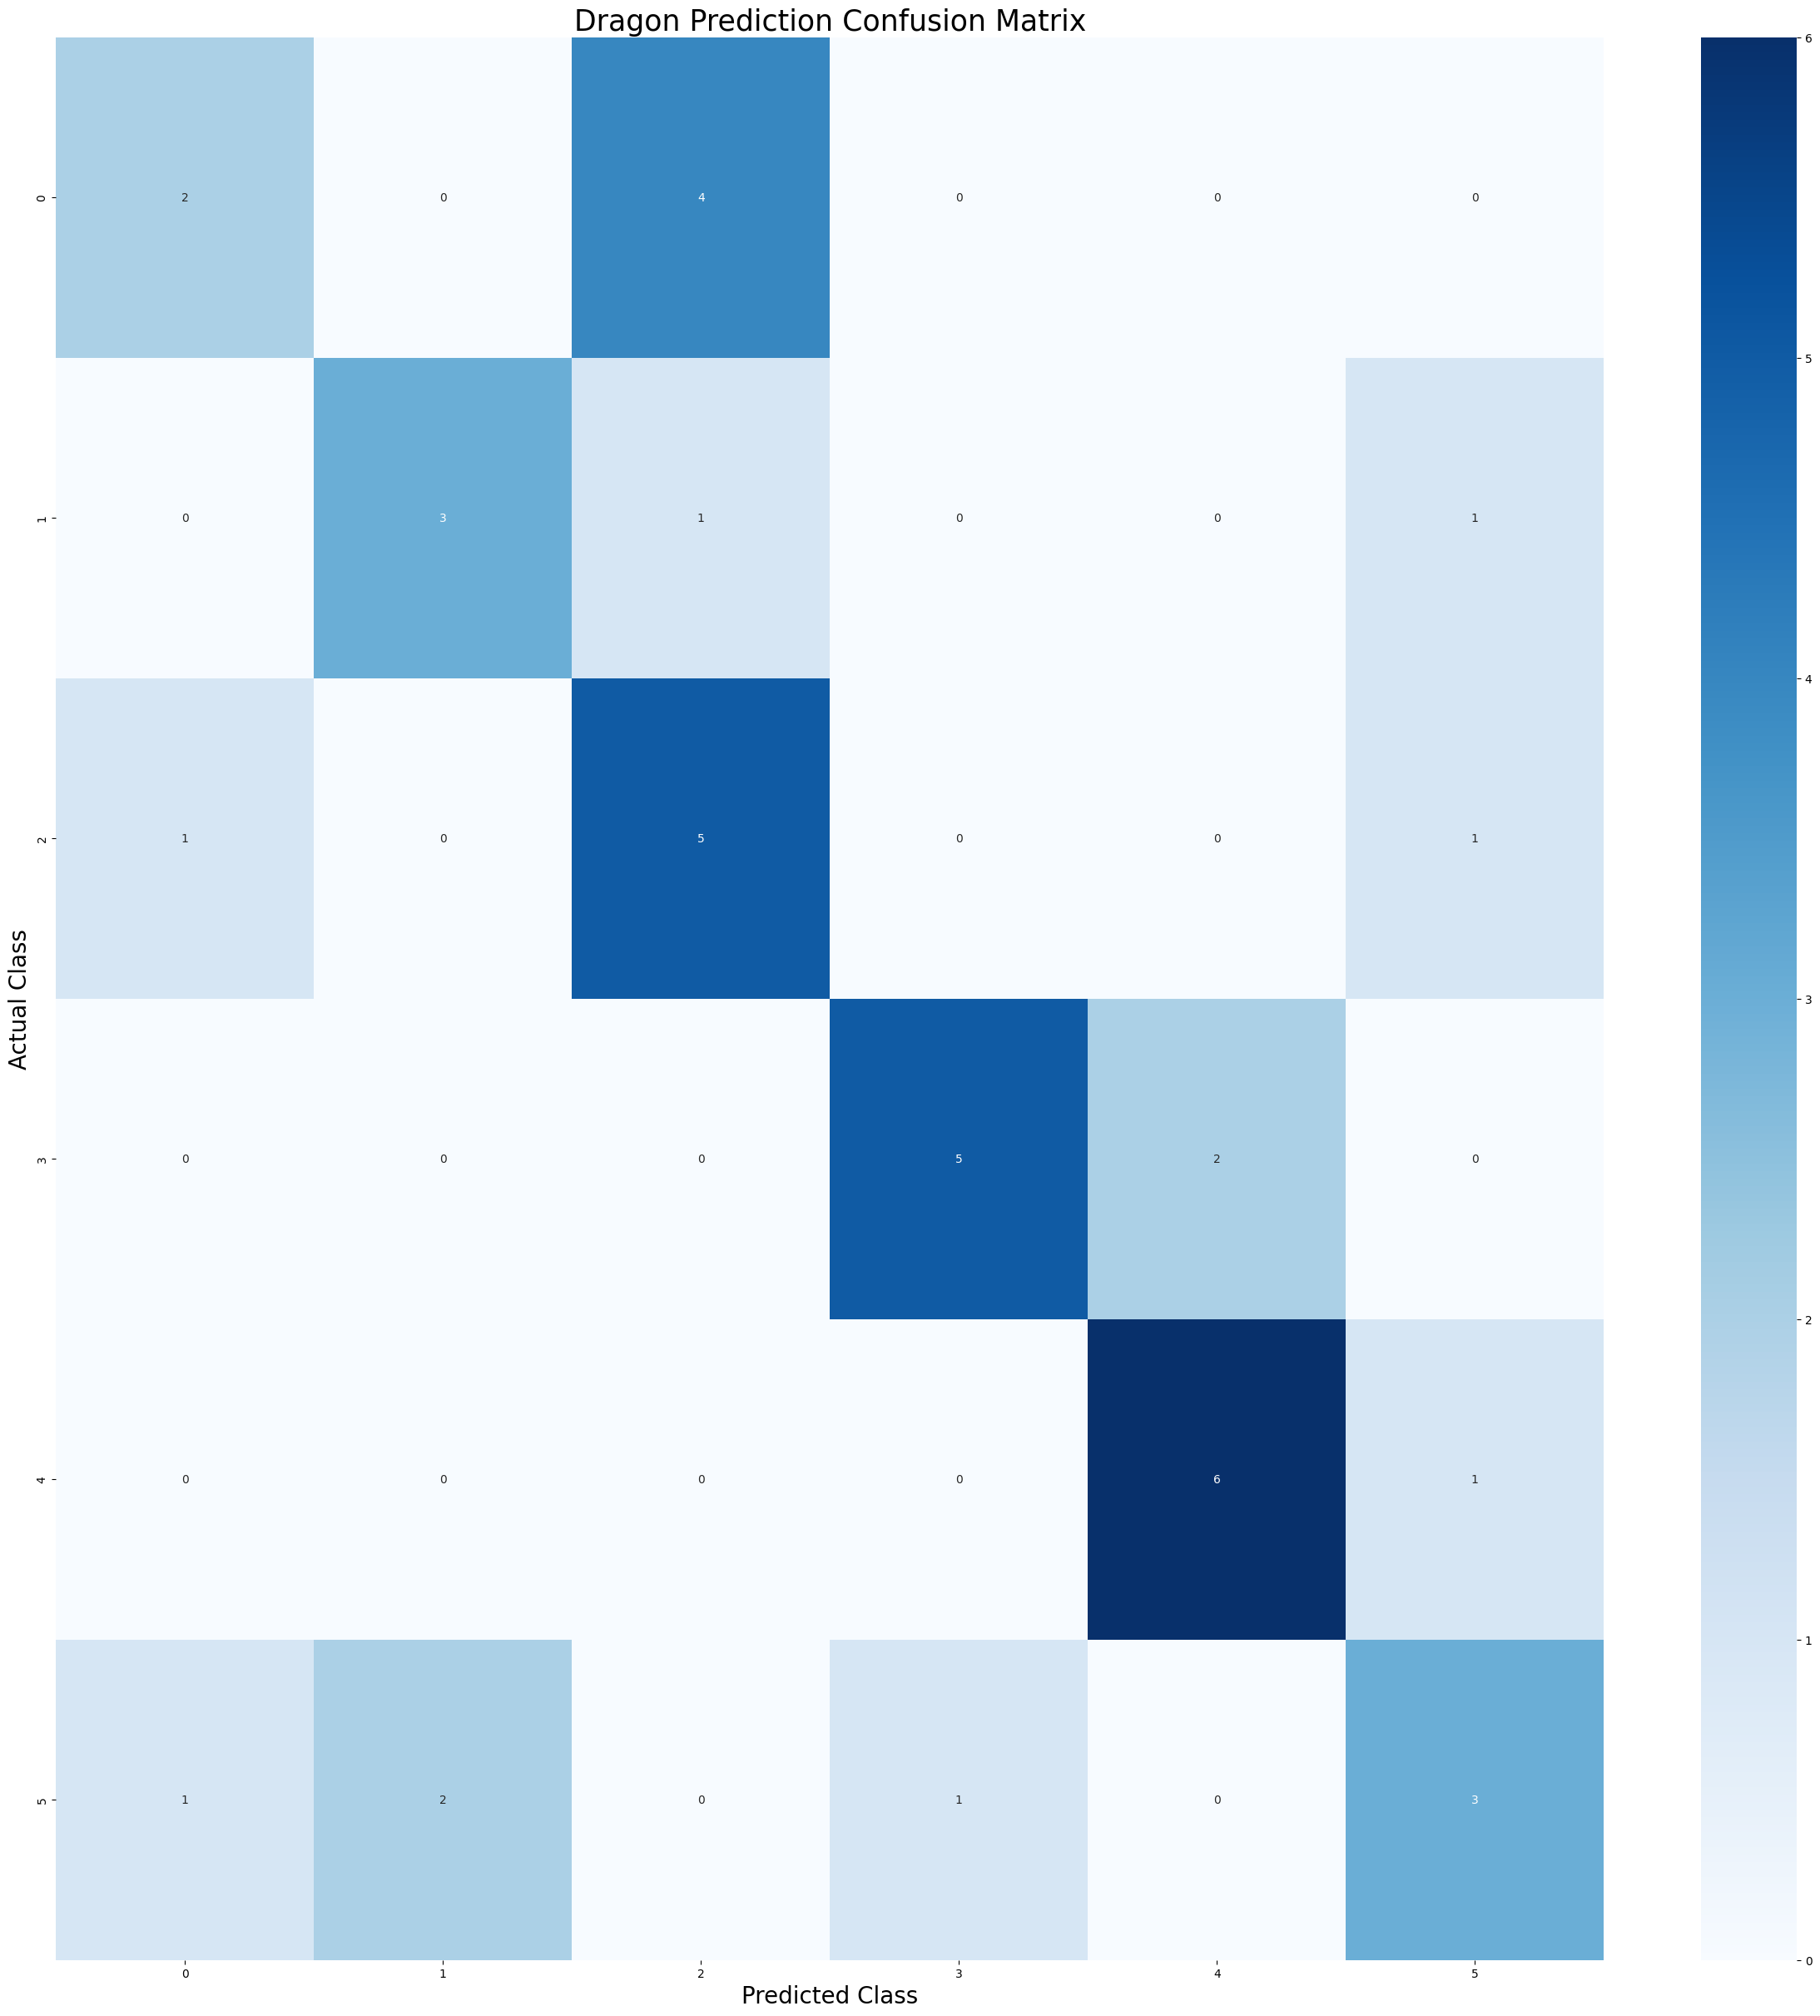

<Figure size 640x480 with 0 Axes>

In [38]:
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(30, 30))
sns.heatmap(cm, annot=True, annot_kws={"size": 10}, cmap='Blues')
plt.xlabel('Predicted Class', fontsize=20)
plt.ylabel('Actual Class', fontsize=20)
plt.title('Dragon Prediction Confusion Matrix', fontsize=25)
plt.show()
plt.savefig("drive/MyDrive/nn/confusion_matrix.jpg")